# Code for Authorship Analysis of QUESTA

By [Aapeli Vuorinen](https://www.aapelivuorinen.com).

Note that this code is pretty rough, feel free to get in touch if you need help or find it useful.

You need to download a copy of the DBLP data in XML format and the associated `.dtd` file from

<https://dblp.org/xml/>

You will also need the file `dois` that contains a list of DOIs from Springer, as well as `insts.csv` which lists the institutions of authors on those papers according to Springer.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
from lxml import etree
from lxml.etree import XMLSyntaxError
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [3]:
with open("dois") as f:
    dois = set(f.read().lower().split())

In [4]:
len(dois)

1756

In [5]:
source = "dblp.xml"
dtd = etree.DTD(file="dblp.dtd")

In [6]:
authors_for_doi = {}
year_for_doi = {}

found_dois = []

found = 0
for event, element in tqdm(etree.iterparse(source, load_dtd=True)):
    include = False
    authors = []
    year = None
    for child in element:
        if child.tag == "ee":
            pfx = "https://doi.org/"
            text = child.text.lower()
            if text.startswith(pfx):
                doi = text[len(pfx):]
                if doi in dois:
                    found += 1
                    include = True
                    found_dois.append(doi)
        if child.tag == "author":
            authors.append(child.text)
        if child.tag == "year":
            year = child.text
    if include:
        authors_for_doi[doi] = authors
        if year:
            year_for_doi[doi] = year

78069024it [01:53, 686737.19it/s]


In [7]:
len(found_dois)

1725

In [8]:
with open("found_dois", "w+") as o:
    o.write("\n".join(sorted(found_dois)))

In [9]:
dois_for_authors = {}
for doi, authors in authors_for_doi.items():
    for author in authors:
        if author in dois_for_authors:
            dois_for_authors[author] |= set([doi])
        else:
            dois_for_authors[author] = set([doi])

In [10]:
author_freqs = {}
for doi, authors in authors_for_doi.items():
    for author in authors:
        author_freqs[author] = author_freqs.get(author, 0) + 1

In [11]:
all_authors = set(author_freqs.keys())

In [12]:
author_freq_list = list(author_freqs.items())
author_freq_list.sort(key=lambda x: -x[1])

(array([113., 151., 216., 160., 216., 166., 195., 155., 187., 166.]),
 array([1986. , 1989.5, 1993. , 1996.5, 2000. , 2003.5, 2007. , 2010.5,
        2014. , 2017.5, 2021. ]),
 <BarContainer object of 10 artists>)

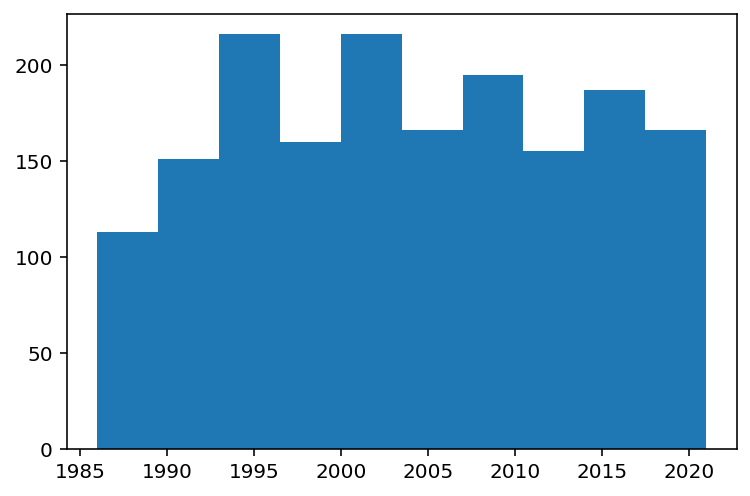

In [13]:
years_arr = np.array(list(year_for_doi.values()), np.int32)
plt.hist(years_arr)

In [14]:
authors_for_years = {}
for doi, year in year_for_doi.items():
    if year not in authors_for_years:
        authors_for_years[year] = set()
    authors_for_years[year] |= set(authors_for_doi[doi])

In [15]:
already_seen_authors_for_years = {}
first = True
for year in sorted(authors_for_years.keys()):
# for year, authors in authors_for_years.items():
    authors = authors_for_years[year]
    if first:
        already_seen_authors_for_years[year] = authors
        first = False
    else:
        last_year = str(int(year)-1)
        already_seen_authors_for_years[year] = authors | already_seen_authors_for_years[last_year]

In [16]:
for year, a in already_seen_authors_for_years.items():
    print(f"{year=}, {len(a)=}")

year='1986', len(a)=25
year='1987', len(a)=55
year='1988', len(a)=87
year='1989', len(a)=148
year='1990', len(a)=209
year='1991', len(a)=257
year='1992', len(a)=314
year='1993', len(a)=355
year='1994', len(a)=431
year='1995', len(a)=488
year='1996', len(a)=519
year='1997', len(a)=559
year='1998', len(a)=604
year='1999', len(a)=652
year='2000', len(a)=698
year='2001', len(a)=738
year='2002', len(a)=781
year='2003', len(a)=812
year='2004', len(a)=867
year='2005', len(a)=913
year='2006', len(a)=962
year='2007', len(a)=1010
year='2008', len(a)=1038
year='2009', len(a)=1080
year='2010', len(a)=1118
year='2011', len(a)=1157
year='2012', len(a)=1213
year='2013', len(a)=1239
year='2014', len(a)=1284
year='2015', len(a)=1327
year='2016', len(a)=1373
year='2017', len(a)=1416
year='2018', len(a)=1460
year='2019', len(a)=1502
year='2020', len(a)=1547
year='2021', len(a)=1573


In [17]:
new_authors_for_years = {}
for year, asa in already_seen_authors_for_years.items():
    last_year = str(int(year)-1)
    new_authors_for_years[year] = authors_for_years[year] - already_seen_authors_for_years.get(last_year, set())

In [18]:
new_authors_per_year = list({year: len(a) for year, a in new_authors_for_years.items()}.items())
new_authors_per_year_prop = list({year: len(a)/len(authors_for_years[year]) for year, a in new_authors_for_years.items()}.items())

In [19]:
years, new_auth_count_prop = zip(*new_authors_per_year_prop)
years, new_auth_count = zip(*new_authors_per_year)

In [20]:
np.mean(new_auth_count)

43.69444444444444

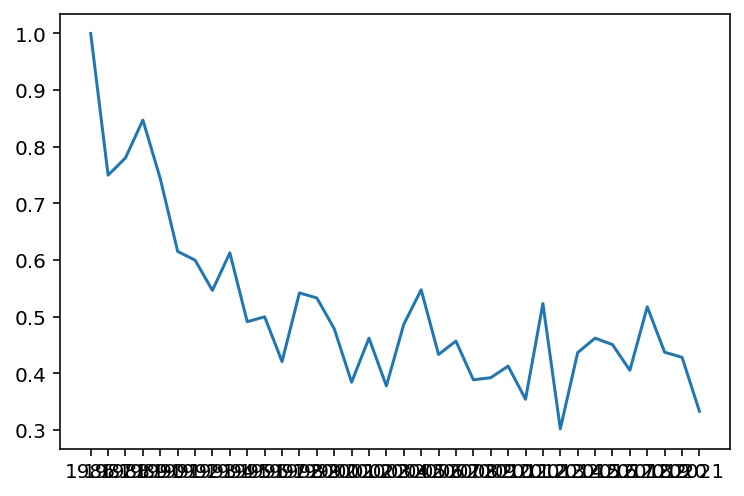

In [21]:
plt.plot(years, new_auth_count_prop)

In [22]:
dois_for_authors_gt5 = {key: value for key, value in dois_for_authors.items() if len(value) >= 5}

In [23]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

In [24]:
len(set(flatten(dois_for_authors.values())))

1718

In [25]:
len(set(flatten(dois_for_authors_gt5.values())))

1124

In [26]:
pubs_per_author = np.array(list(map(len, dois_for_authors.values())))

In [27]:
np.mean(pubs_per_author[pubs_per_author >= 5])

8.948571428571428

In [28]:
nums = ["$1$", "$2$", "$3$", "$4$", "$\geq 5$"]
vals = [
    np.sum(pubs_per_author == 1),
    np.sum(pubs_per_author == 2),
    np.sum(pubs_per_author == 3),
    np.sum(pubs_per_author == 4),
    np.sum(pubs_per_author >= 5)
]

In [29]:
np.mean(pubs_per_author >= 5)

0.11125238397965671

In [30]:
pubs_per_author

array([1, 2, 6, ..., 1, 1, 1])

In [31]:
np.sum(pubs_per_author >= 5)

175

In [32]:
len(all_authors)

1573

In [33]:
authors_per_doi = np.array(list(map(len, authors_for_doi.values())))

In [34]:
apd_nums = []
apd_vals = []
for i in np.arange(np.max(authors_per_doi))+1:
    apd_nums.append(str(i))
    apd_vals.append(np.sum(authors_per_doi == i))

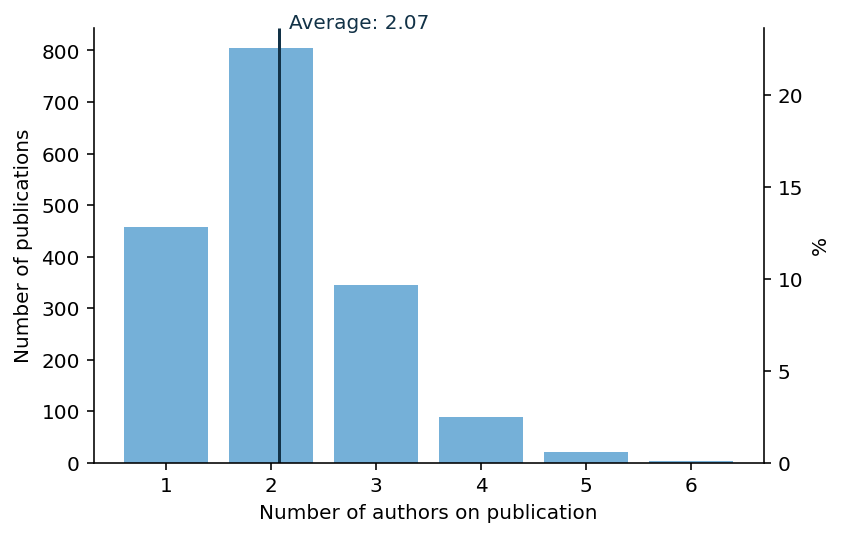

In [35]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(apd_nums, apd_vals, color="#75b0d8")

# plt.title("Distribution of number of authors per publication")
# plt.axis("off")
plt.xlabel("Number of authors on publication")
plt.ylabel("Number of publications")
mean = np.mean(authors_per_doi)
ax.vlines([mean-1], 0, 1, transform=ax.get_xaxis_transform(), colors="#123247")


ax.annotate(f"Average: {mean:.2f}", xy=(mean-1, 815),
            xytext=(5, 5), textcoords="offset points",
            horizontalalignment="left",
            verticalalignment="bottom",
            color="#123247")

def to_pct(x):
    return x / np.sum(authors_per_doi) * 100

def from_pct(x):
    return x * np.sum(authors_per_doi) / 100

secax = ax.secondary_yaxis("right", functions=(to_pct, from_pct))
secax.set_ylabel("%")

plt.savefig("figs2/authors_per_pub.pdf")

In [36]:
np.mean(authors_per_doi)

2.070724637681159

In [37]:
np.sum(authors_per_doi == 0)

7

(array([  7., 458.,   0., 804.,   0., 344.,  89.,   0.,  20.,   3.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

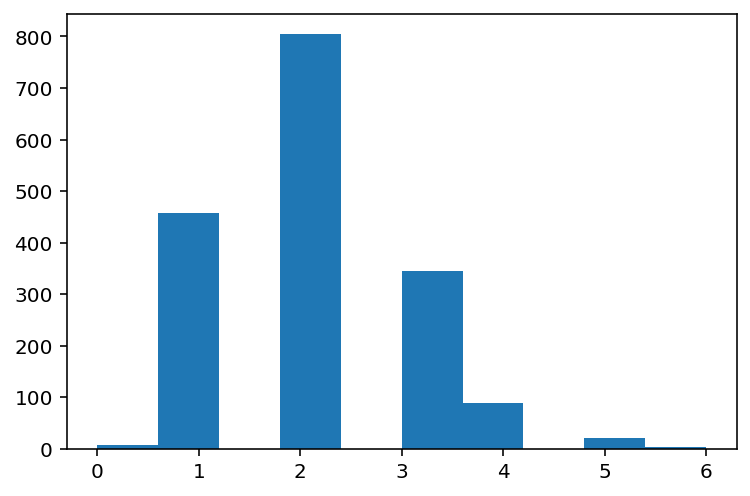

In [38]:
plt.hist(authors_per_doi)

In [39]:
len(authors_for_doi.keys())

1725

In [40]:
len(found_dois)

1725

In [41]:
np.mean(pubs_per_author)

2.2708200890019072

In [42]:
vals[0]

989

In [43]:
np.sum(pubs_per_author)

3572

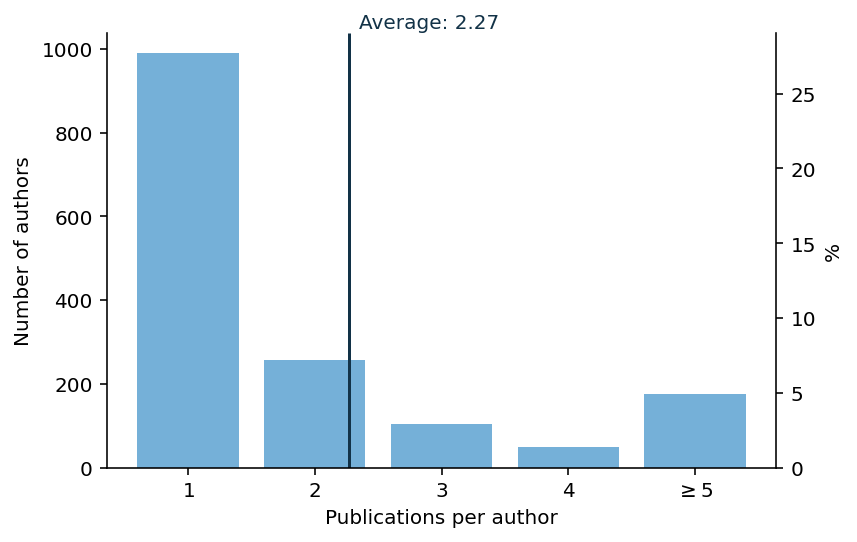

In [44]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(nums, vals, color="#75b0d8")


# plt.axis("off")
# plt.title("Distribution of number of publication per author")
plt.xlabel("Publications per author")
plt.ylabel("Number of authors")
mean = np.mean(pubs_per_author)
ax.vlines([mean-1], 0, 1, transform=ax.get_xaxis_transform(), colors="#123247")


ax.annotate(f"Average: {mean:.2f}", xy=(mean-1, 1015),
            xytext=(5, 5), textcoords="offset points",
            horizontalalignment="left",
            verticalalignment="bottom",
            color="#123247")

def to_pct(x):
    return x / np.sum(pubs_per_author) * 100

def from_pct(x):
    return x * np.sum(pubs_per_author) / 100

secax = ax.secondary_yaxis("right", functions=(to_pct, from_pct))
secax.set_ylabel("%")

# plt.title("Number of publications per author")
plt.savefig("figs2/pubs_per_author.pdf")

(0.0, 10.0)

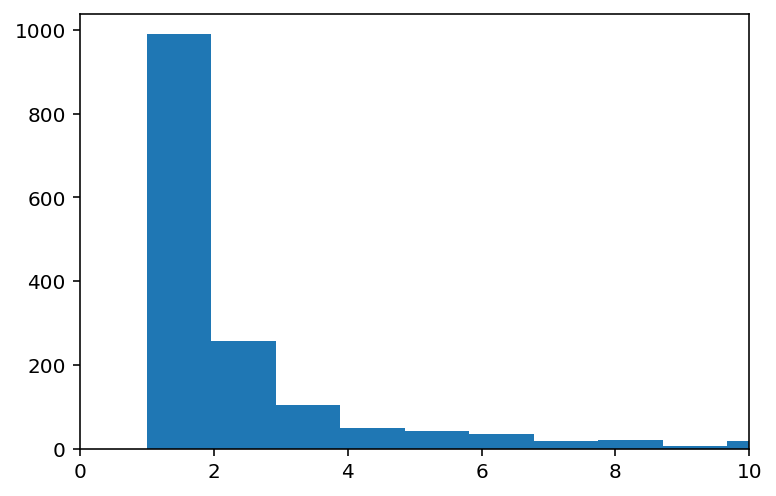

In [45]:
plt.hist(pubs_per_author, bins=pubs_per_author.max()+1)
plt.xlim(0, 10)

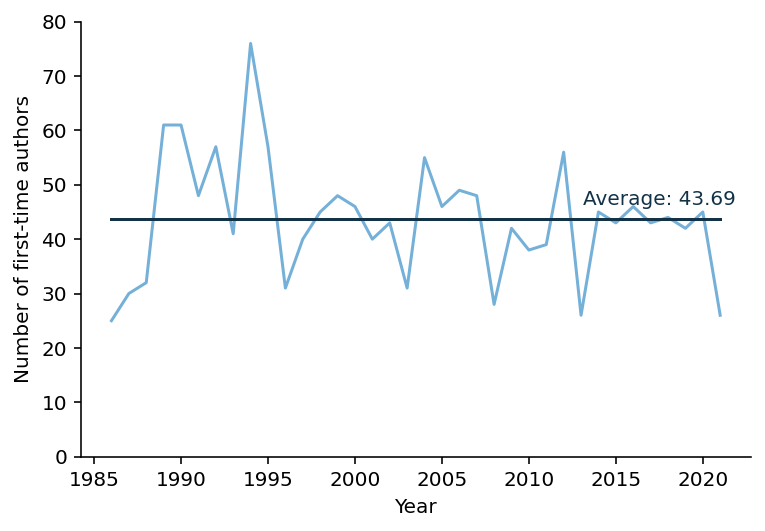

In [46]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.plot(list(map(int, years)), new_auth_count, color="#75b0d8")
plt.ylim(0, 80)
plt.xlabel("Year")
plt.ylabel("Number of first-time authors")
avg = sum(new_auth_count)/len(years)
plt.plot(list(map(int, years)), [avg]*len(new_auth_count), color="#123247")

ax.annotate(f"Average: {avg:.2f}", xy=(2020, avg),
            xytext=(-60, 5), textcoords="offset points",
            horizontalalignment="left",
            verticalalignment="bottom",
            color="#123247")
# plt.plot(years, np.cumsum(auth_count))
# plt.title("Number of first time authors over time")
plt.savefig("figs2/first_time_authors.pdf")

In [47]:
avg

43.69444444444444

In [48]:
for year, a in new_authors_for_years.items():
    print(f"{year=}, {len(a)=}")

year='1986', len(a)=25
year='1987', len(a)=30
year='1988', len(a)=32
year='1989', len(a)=61
year='1990', len(a)=61
year='1991', len(a)=48
year='1992', len(a)=57
year='1993', len(a)=41
year='1994', len(a)=76
year='1995', len(a)=57
year='1996', len(a)=31
year='1997', len(a)=40
year='1998', len(a)=45
year='1999', len(a)=48
year='2000', len(a)=46
year='2001', len(a)=40
year='2002', len(a)=43
year='2003', len(a)=31
year='2004', len(a)=55
year='2005', len(a)=46
year='2006', len(a)=49
year='2007', len(a)=48
year='2008', len(a)=28
year='2009', len(a)=42
year='2010', len(a)=38
year='2011', len(a)=39
year='2012', len(a)=56
year='2013', len(a)=26
year='2014', len(a)=45
year='2015', len(a)=43
year='2016', len(a)=46
year='2017', len(a)=43
year='2018', len(a)=44
year='2019', len(a)=42
year='2020', len(a)=45
year='2021', len(a)=26


In [49]:
years = list(set(year_for_doi.values()))

In [50]:
inst_df = pd.read_csv("insts.csv", header=None)

In [51]:
all_institutions = set()
for inst_str in inst_df[1].unique():
    all_institutions |= set(inst_str.split("|"))

In [52]:
len(all_institutions)

535

In [53]:
insts_for_doi = {}
for _, (doi, insts) in inst_df.iterrows():
    if doi in found_dois:
        insts_for_doi[doi] = insts.split("|")

In [54]:
dois_for_inst = {}
for doi, insts in insts_for_doi.items():
    for inst in insts:
        if inst not in dois_for_inst:
            dois_for_inst[inst] = list()
        dois_for_inst[inst].append(doi)

In [55]:
pub_counts_per_inst = sorted(list({inst: len(dois) for inst, dois in dois_for_inst.items()}.items()), key=lambda x: -x[1])

In [56]:
sum(list(map(lambda x: x[1], pub_counts_per_inst[:10])))

575

In [57]:
#pub_counts_per_inst

(array([497.,  21.,   8.,   3.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([  1. ,  14.5,  28. ,  41.5,  55. ,  68.5,  82. ,  95.5, 109. ,
        122.5, 136. ]),
 <BarContainer object of 10 artists>)

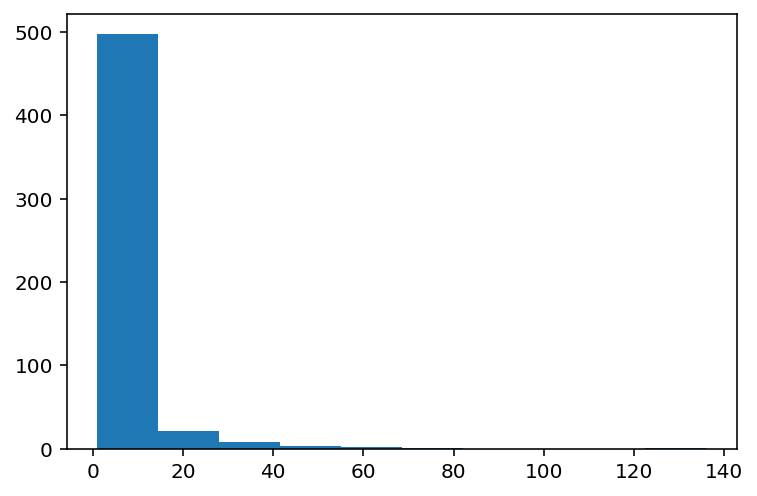

In [58]:
plt.hist(list(map(lambda x: x[1], pub_counts_per_inst)))

In [59]:
dois_for_years = {}
for doi, year in year_for_doi.items():
    if year not in dois_for_years:
        dois_for_years[year] = []
    dois_for_years[year].append(doi)

In [60]:
years_arr

array([2004, 1996, 2013, ..., 1993, 2010, 2001], dtype=int32)

(array([381., 475., 469., 400.]),
 array([1986.  , 1994.75, 2003.5 , 2012.25, 2021.  ]),
 <BarContainer object of 4 artists>)

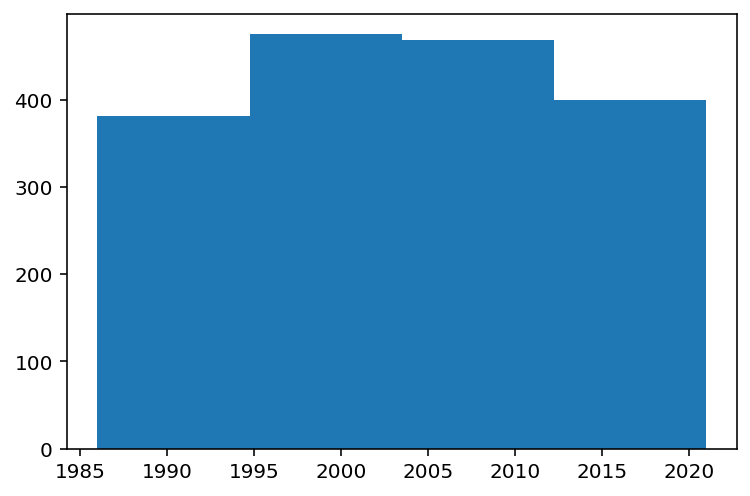

In [61]:
plt.hist(years_arr, bins=4)

In [62]:
x = [0,0,0,0]

In [63]:
x[0] = np.mean(years_arr <= 1995)

In [64]:
x[1]=np.mean(years_arr <= 2003)

In [65]:
x[2]=np.mean(years_arr <= 2012)

In [66]:
x[3]=np.mean(years_arr > 2012)

In [67]:
np.min(years_arr), np.max(years_arr)

(1986, 2021)

In [68]:
chunk_props = []
chunks = []
last = None
for x in 1986+9*np.arange(5)-1:
    if last:
        print(f">{last}, <={x}")
        chunk_props.append(np.mean((last < years_arr) & (years_arr <= x)))
        print(np.mean((last < years_arr) & (years_arr <= x)))
        chunks.append([key for key, value in year_for_doi.items() if last < int(value) <= x])
    last = x

>1985, <=1994
0.22086956521739132
>1994, <=2003
0.2753623188405797
>2003, <=2012
0.2718840579710145
>2012, <=2021
0.2318840579710145


In [69]:
for x in 1986+9*np.arange(4):
    print(np.mean(years_arr <= x))

0.011594202898550725
0.25565217391304346
0.5315942028985507
0.7953623188405797


In [70]:
Gs = []
author_freqs_s = []
author_freq_lists = []
Hs = []
for chunk in chunks:
    G = nx.Graph()
    author_freqs = {}
    count = 0
    joint_author_freqs = {}
    for doi, authors in authors_for_doi.items():
        if doi in chunk:
            count += 1
            if count > 10000:
                break
            for author1 in authors:
                author_freqs[author1] = author_freqs.get(author1, 0) + 1
                for author2 in authors:
                    if author1 < author2:
                        joint_author_freqs[(author1, author2)] = joint_author_freqs.get((author1, author2), 0) + 1
    # nx.draw(G)
    for author in author_freqs.keys():
        G.add_node(author)
    for (author1, author2), weight in joint_author_freqs.items():
        G.add_edge(author1, author2, weight=weight)
    Gs.append(G)
    author_freqs_s.append(author_freqs)
    author_freq_list_ = list(author_freqs.items())
    author_freq_list_.sort(key=lambda x: -x[1])
    author_freq_lists.append(author_freq_list_)
    components = list(nx.connected_components(G))
    component_size = np.array([len(c) for c in components])
    main_component = [c for c in components if len(c) == np.max(component_size)][0]
    H = G.subgraph(main_component)
    Hs.append(H)

In [71]:
G = nx.Graph()
author_freqs = {}
count = 0
joint_author_freqs = {}
for doi, authors in authors_for_doi.items():
    count += 1
    if count > 10000:
        break
    for author1 in authors:
        if author1 in author_freqs:
            author_freqs[author1] = author_freqs.get(author1, 0) + 1
        for author2 in authors:
            if author1 < author2:
                joint_author_freqs[(author1, author2)] = joint_author_freqs.get((author1, author2), 0) + 1
# nx.draw(G)
for author in author_freqs.keys():
    G.add_node(author)
for (author1, author2), weight in joint_author_freqs.items():
    G.add_edge(author1, author2, weight=weight)

In [72]:
components = list(nx.connected_components(G))

In [73]:
component_size = np.array([len(c) for c in components])

In [74]:
main_component = [c for c in components if len(c) == np.max(component_size)][0]

In [75]:
print(len(main_component))

1024


In [76]:
other_components = [c for c in components if len(c) != np.max(component_size)]

(array([83., 41., 17.,  8.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

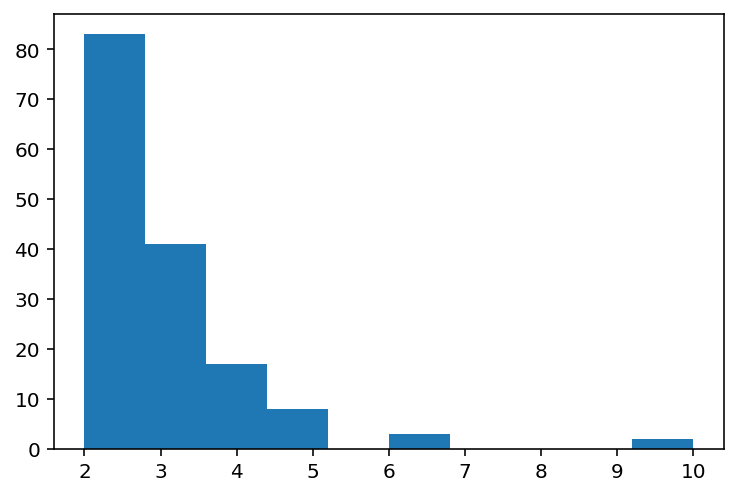

In [77]:
plt.hist([len(c) for c in other_components], bins=10)

In [78]:
H = G.subgraph(main_component)

In [79]:
len(G)

1459

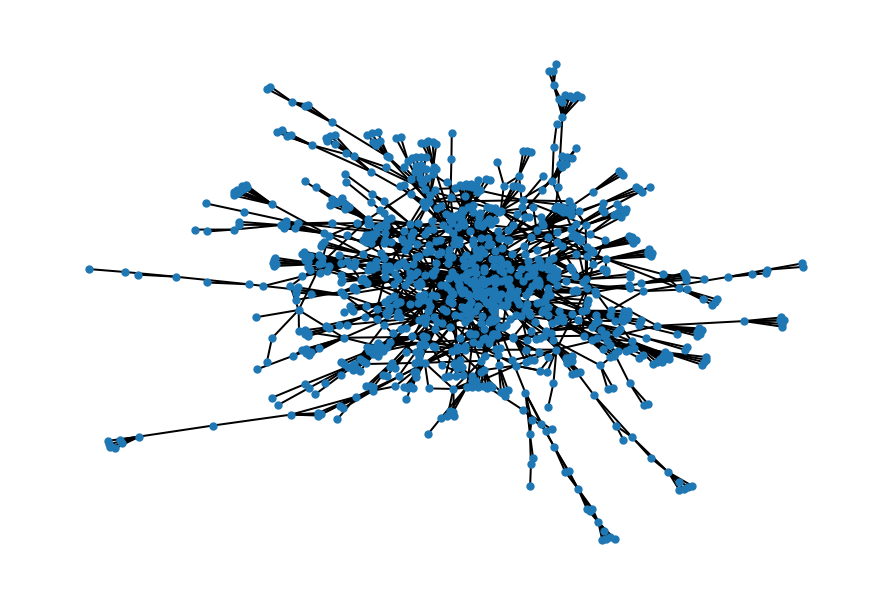

In [80]:
nx.draw_spring(H, node_size=10)

In [81]:
sorted_comps = sorted(components, key=len, reverse=True)

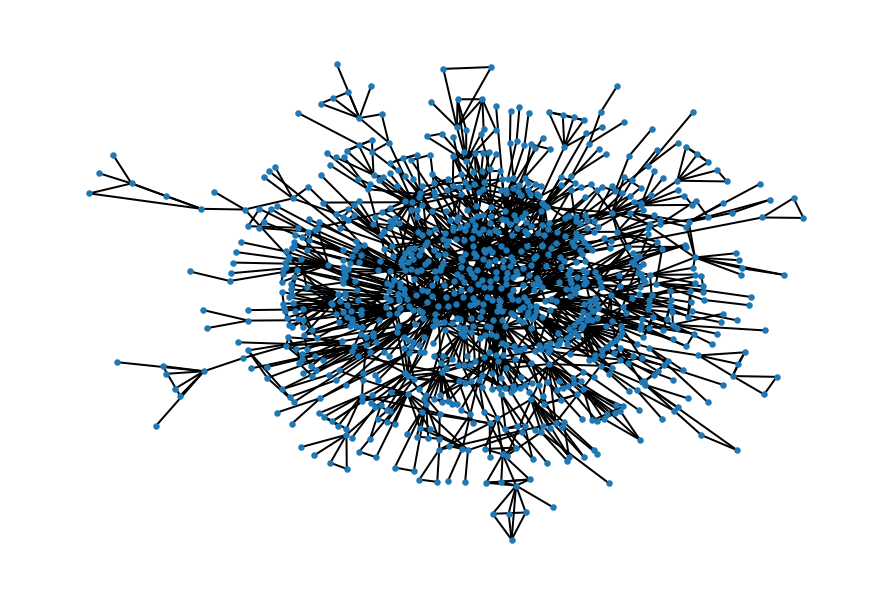

In [82]:
main_comp = G.subgraph(sorted_comps[0])
l1 = nx.kamada_kawai_layout(main_comp)
nx.draw(main_comp, l1, node_size=5)

In [83]:
all_other_comps = flatten(sorted_comps[1:])

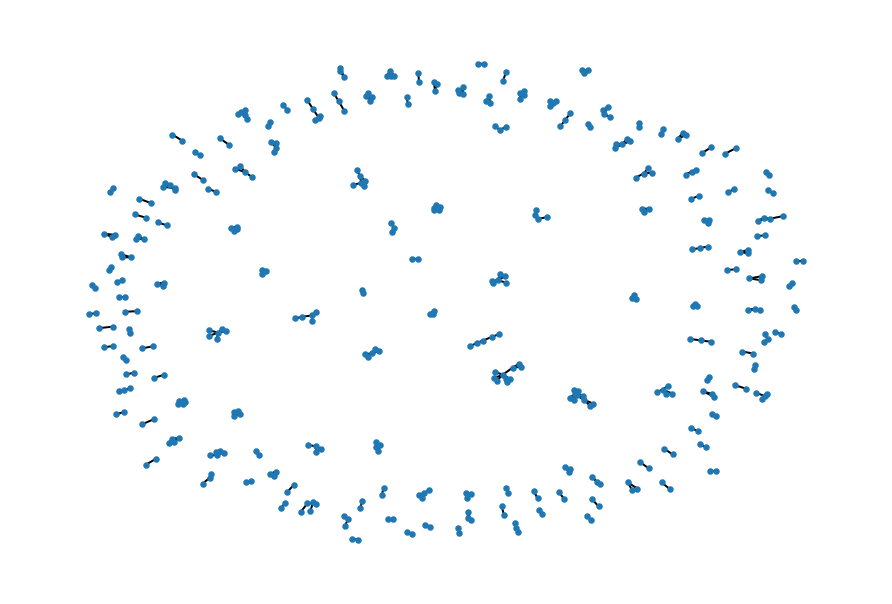

In [84]:
not_main_comp = G.subgraph(all_other_comps)
l2 = nx.spring_layout(not_main_comp)
nx.draw(not_main_comp, l2, node_size=5)

In [85]:
l3 = dict(l1)
l3.update(l2)

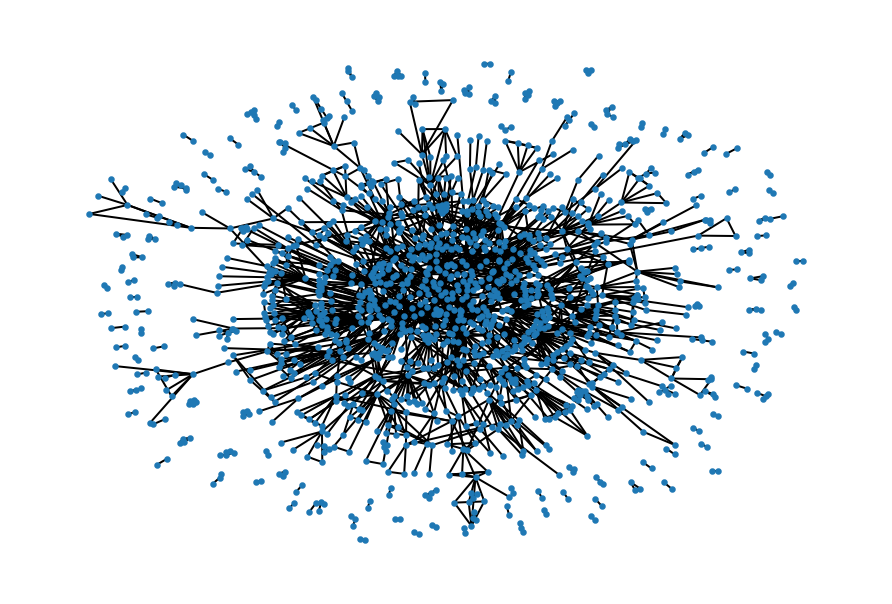

In [86]:
nx.draw(G, l3, node_size=5)
plt.savefig("figs2/graph_illustration.pdf")

In [87]:
C = nx.make_max_clique_graph(G)

In [88]:
max_clique_sizes = np.array([len(c) for c in nx.find_cliques(H)])

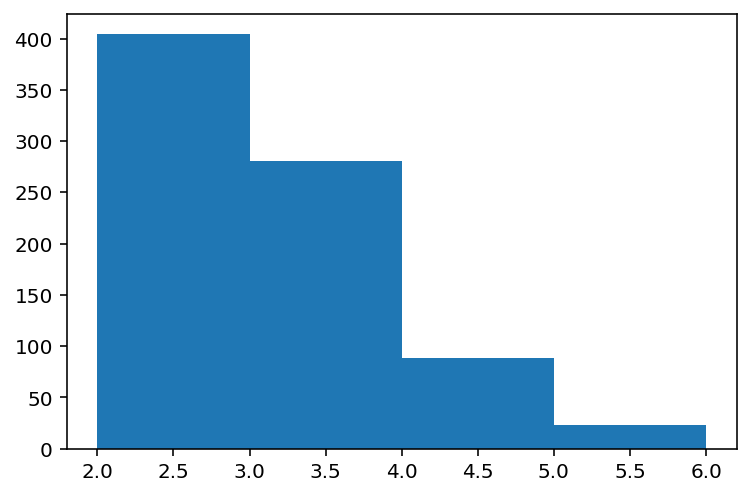

In [89]:
plt.hist(max_clique_sizes, bins=4);

In [90]:
from networkx.algorithms.community import greedy_modularity_communities

In [91]:
communities = list(greedy_modularity_communities(G))

In [92]:
len(H)

1024

In [93]:
len(G)

1459

In [94]:
v_deg = np.array([G.degree[v] for v in G])

In [95]:
v_deg2 = [x for x in v_deg if x < 20]

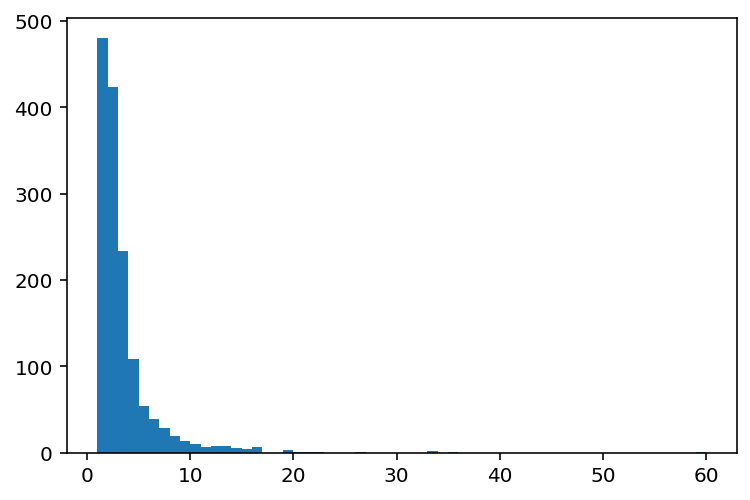

In [96]:
plt.hist(v_deg, bins=59);

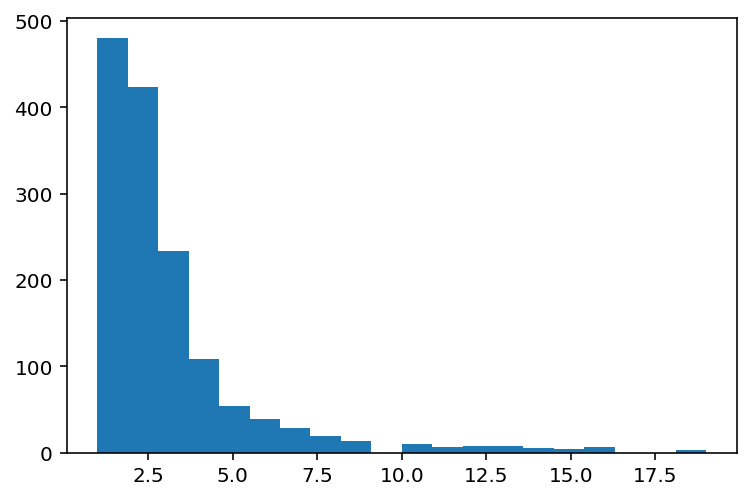

In [97]:
plt.hist(v_deg2, bins=20);

In [98]:
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad/np.mean(x)
    return 0.5 * rmad

In [99]:
pubs = np.array(list(author_freqs.values()))

In [100]:
ginis = []
for i in range(4):
    ginis.append(gini(np.array(list(author_freqs_s[i].values()))))

In [101]:
ginis

[0.3100020247685623,
 0.31240661992874386,
 0.330982676682508,
 0.33833820409516524]

In [102]:
Hs[0]

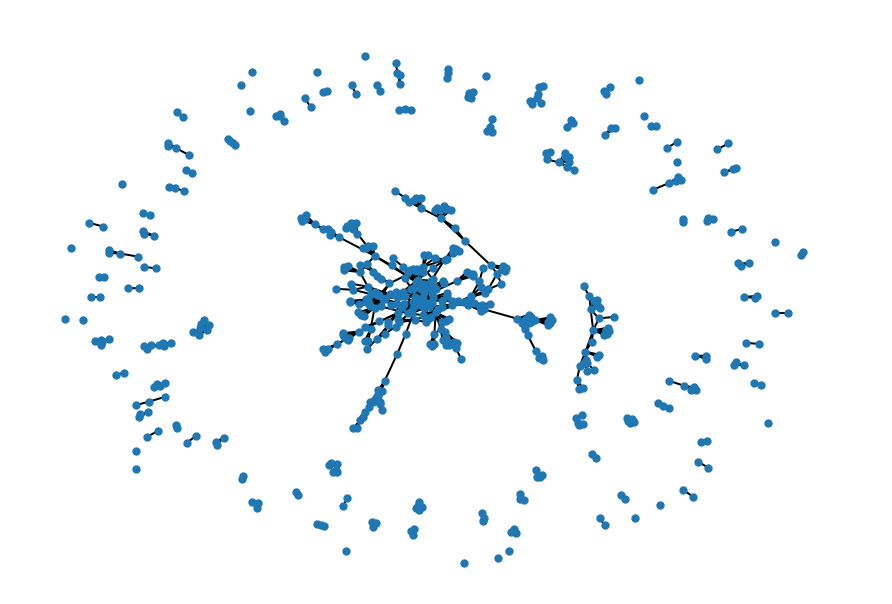

In [103]:
nx.draw_spring(Gs[3], node_size=10)

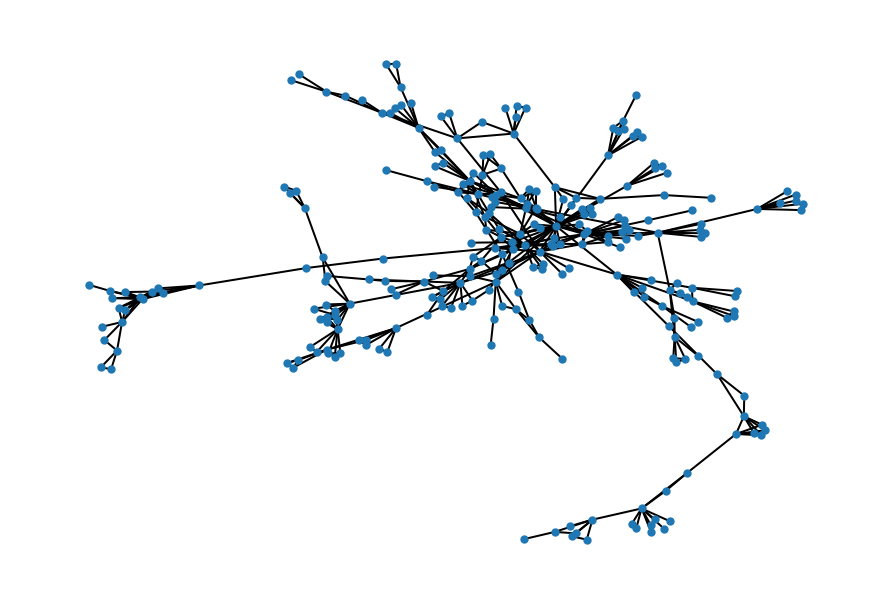

In [104]:
nx.draw_spring(Hs[3], node_size=10)

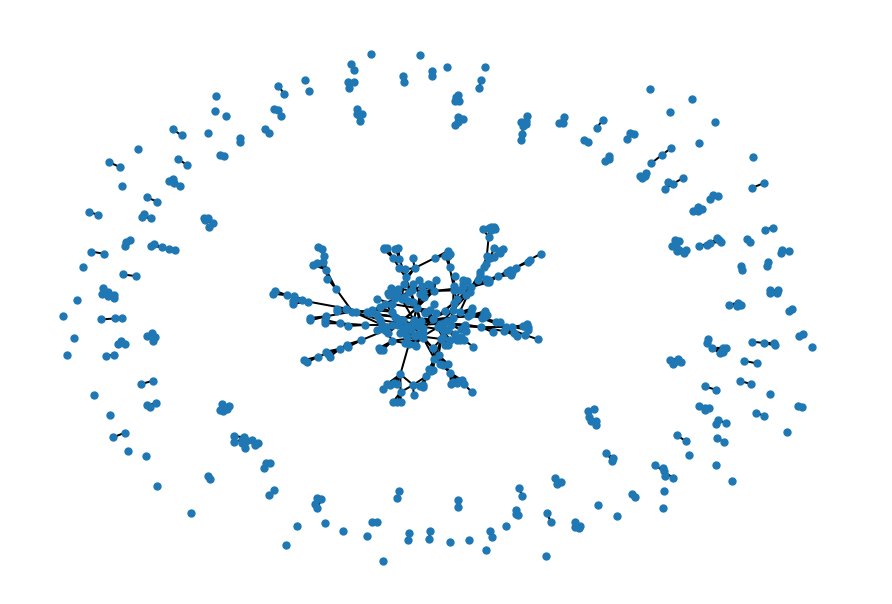

In [105]:
nx.draw_spring(Gs[2], node_size=10)

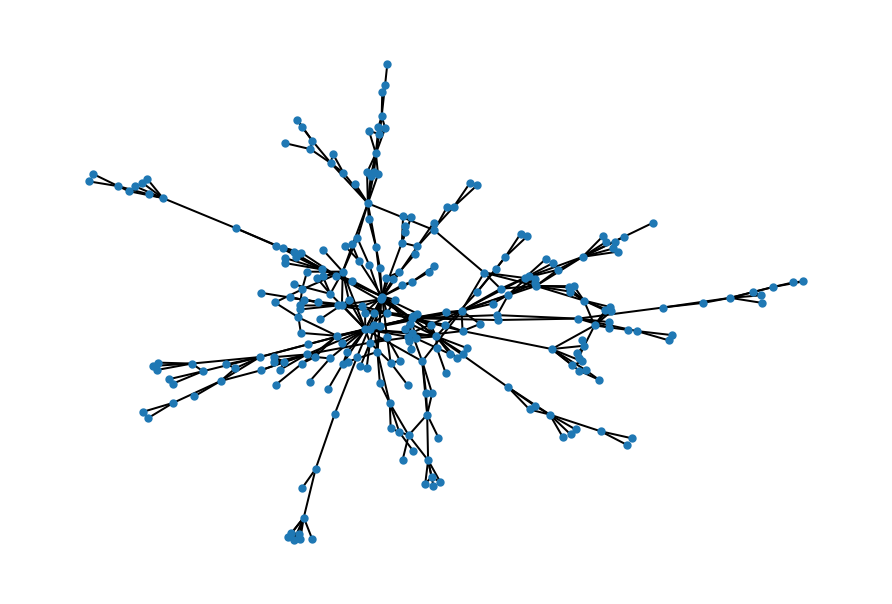

In [106]:
nx.draw_spring(Hs[2], node_size=10)

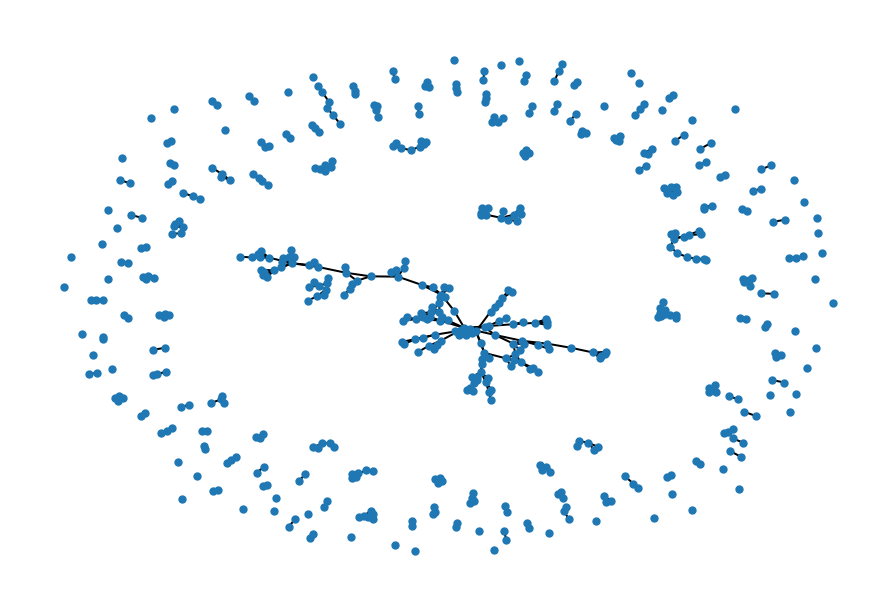

In [107]:
nx.draw_spring(Gs[1], node_size=10)

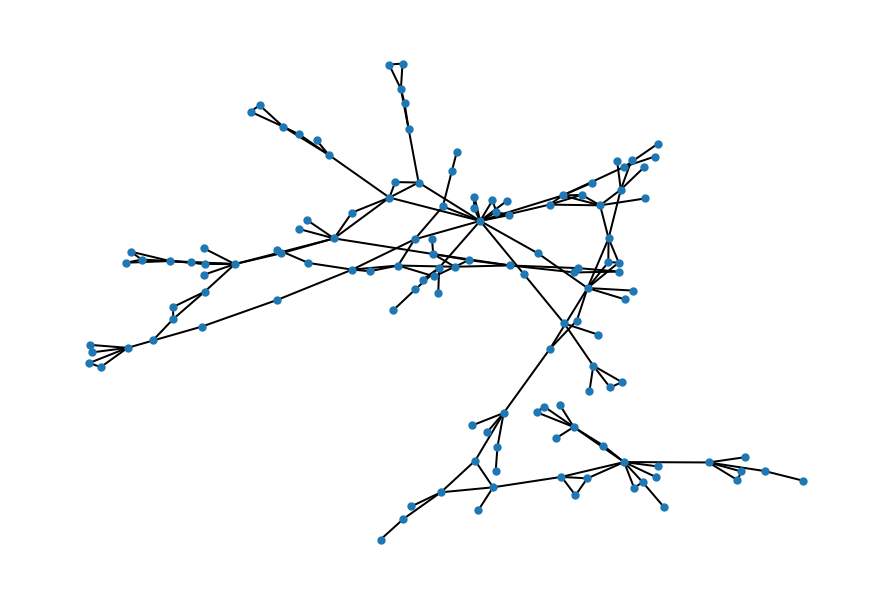

In [108]:
nx.draw_spring(Hs[1], node_size=10)

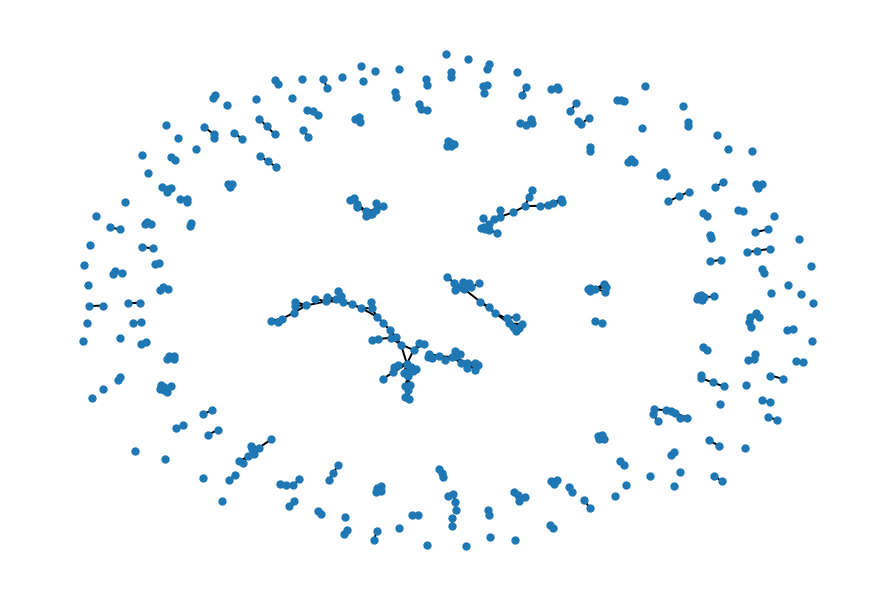

In [109]:
nx.draw_spring(Gs[0], node_size=10)

In [110]:
xxx = np.array(list(map(len, nx.connected_components(G))))
other_comp_sizes = xxx[1:]

In [111]:
# authors in 2-person clusters
2*np.sum(other_comp_sizes == 2)/len(all_authors)

0.10553083280356007

In [112]:
np.histogram(other_comp_sizes, bins=8)

(array([83, 41, 17,  8,  3,  0,  0,  2]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [113]:
cl_vals, cl_counts = np.unique(other_comp_sizes, return_counts=True)

In [114]:
cl_nums = ["$2$", "$3$", "$4$", "$5$", "$\geq 6$"]
cl_vals = [
    np.sum(other_comp_sizes == 2),
    np.sum(other_comp_sizes == 3),
    np.sum(other_comp_sizes == 4),
    np.sum(other_comp_sizes == 5),
    np.sum(other_comp_sizes >= 6)
]

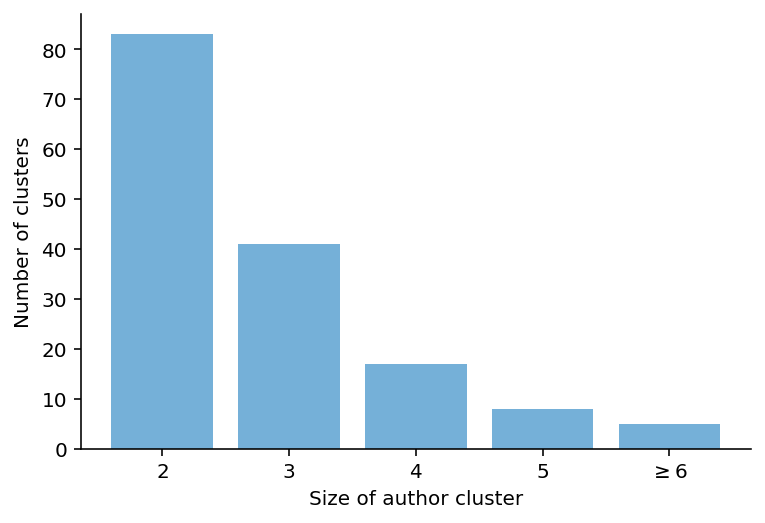

In [115]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(cl_nums, cl_vals, color="#75b0d8")
# plt.title(f"Histogram of cluster size excluding largest")
plt.ylabel("Number of clusters")
plt.xlabel("Size of author cluster")
plt.savefig("figs2/cluster_dist.pdf")

In [116]:
xxx[0]/xxx.sum()

0.7018505825908157

In [117]:
GsSz = []
for i in range(4):
    GsSz.append(np.array(list(map(len, nx.connected_components(Gs[i])))))

In [118]:
i = 0
GsSz[i][GsSz[i] > 10]

array([45, 19, 19, 15, 11])

In [119]:
labels = [
    "1986-1994",
    "1995-2003",
    "2004-2012",
    "2013-2021",
]

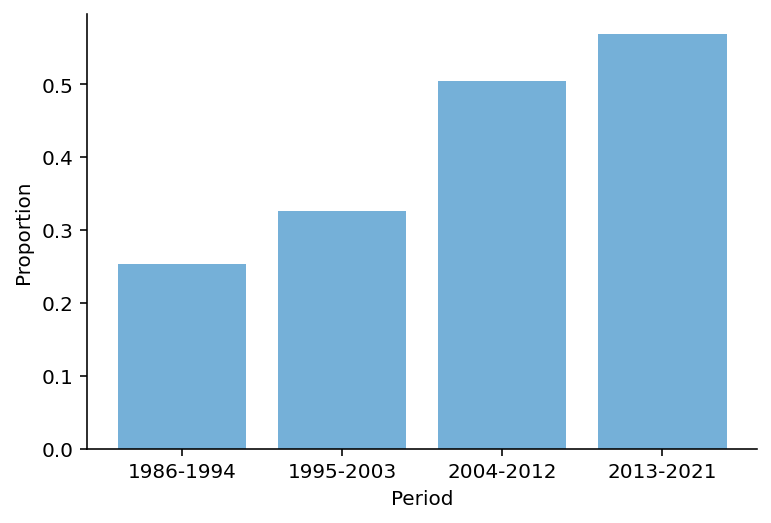

In [120]:
top_c = 5
top_clusters = []
for i in range(4):
    GsSz[i].sort()
    top_clusters.append(np.sum(GsSz[i][-top_c:])/np.sum(GsSz[i]))

fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(labels, top_clusters, color="#75b0d8")
plt.ylabel("Proportion")
# plt.title(f"Proportion of authors in {top_c} largest clusters")
plt.xlabel("Period")
plt.savefig("figs2/top_clusters.pdf")

In [121]:
# top5

In [122]:
GsSz[i].sort()

In [123]:
i = 3
np.sum(GsSz[i][GsSz[i] >= 20])/np.sum(GsSz[i])

0.5258467023172906

In [124]:
i = 3
np.sum(GsSz[i][GsSz[i] > 5])/np.sum(GsSz[i])

0.5793226381461676

In [125]:
GsSz[3]

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   5,   5,   5,   5,   5,   6,   7,   7,  10,
        28, 267])

In [126]:
np.sum(GsSz[3]>15)

2

(array([104.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,  27.6,  54.2,  80.8, 107.4, 134. , 160.6, 187.2, 213.8,
        240.4, 267. ]),
 <BarContainer object of 10 artists>)

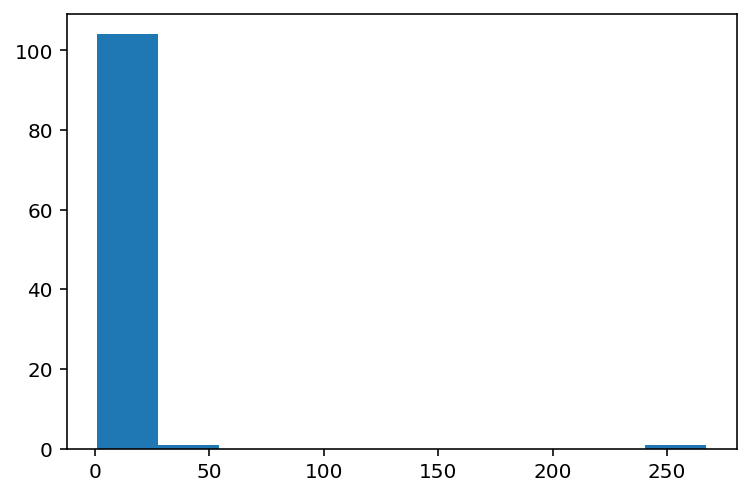

In [127]:
plt.hist(list(map(len, nx.connected_components(Gs[3]))))

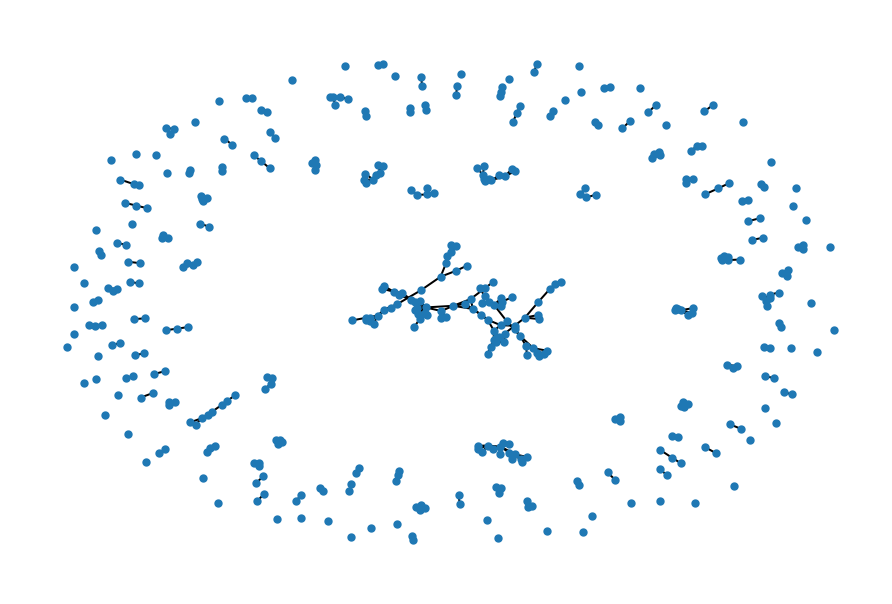

In [128]:
nx.draw_spring(Gs[0], node_size=10)

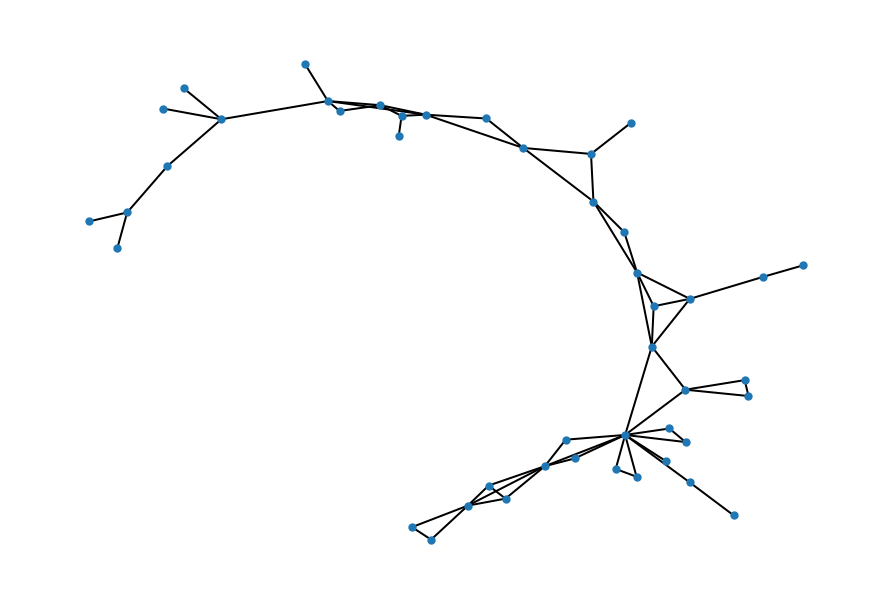

In [129]:
nx.draw_spring(Hs[0], node_size=10)

In [130]:
avg_bacon_numbers = []
cluster_sizes = []
bacons = []
for ix in range(4):
    l = author_freq_lists[ix]

    top = l[0][0]
    bacons.append(top)

    numbers = []

    for author, _ in l:
        try:
            numbers.append(nx.shortest_path_length(Gs[ix], top, author))
        except Exception:
            pass

    avg_bacon_numbers.append(np.mean(numbers))
    cluster_sizes.append(len(numbers))

In [131]:
#bacons

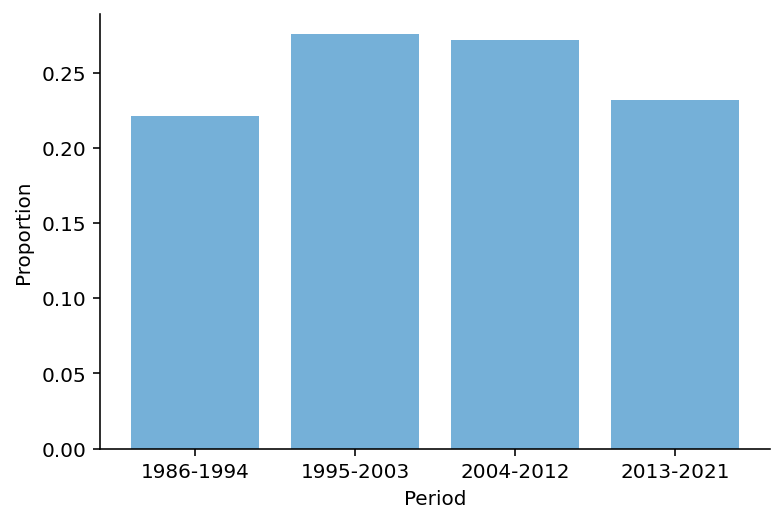

In [132]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(labels, chunk_props, color="#75b0d8")
plt.ylabel("Proportion")
# plt.title("Proportion of papers per period")
plt.xlabel("Period")
plt.savefig("figs2/chunk_prop.pdf")

Text(0.5, 1.0, 'Gini indexes')

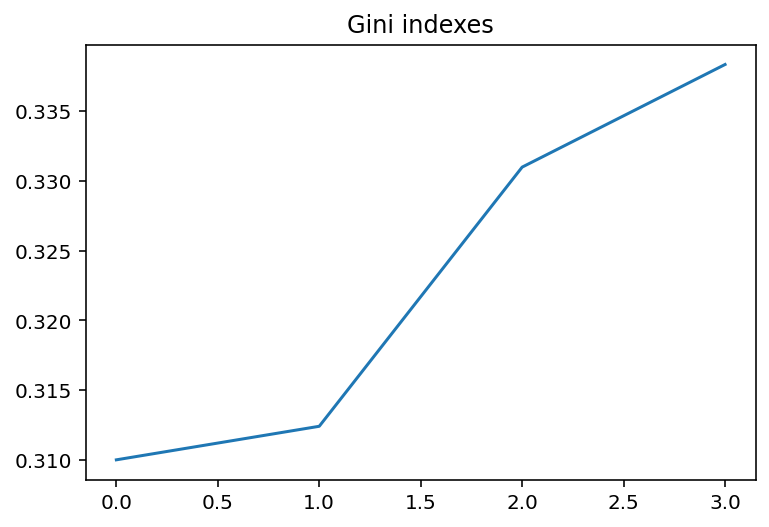

In [133]:
plt.plot(ginis)
plt.title("Gini indexes")

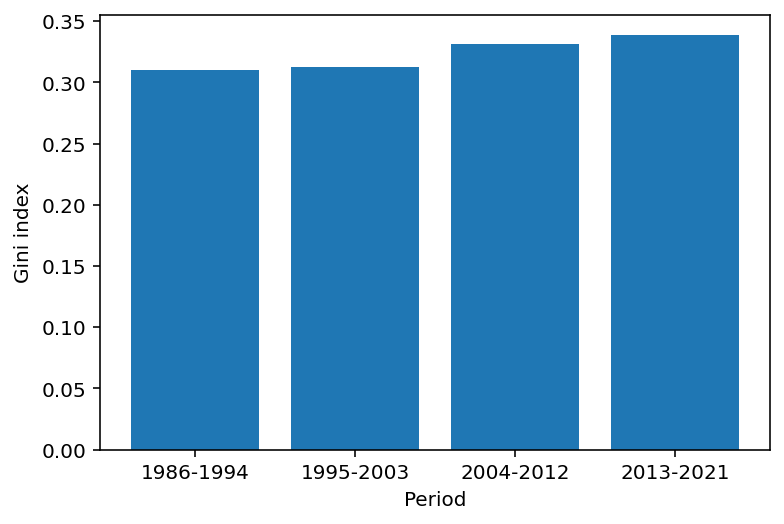

In [134]:
plt.bar(labels, ginis)
# plt.title("Gini indexes")
plt.ylabel("Gini index")
plt.xlabel("Period")
plt.savefig("figs2/gini.pdf")

Text(0.5, 1.0, 'Mean distance to top author')

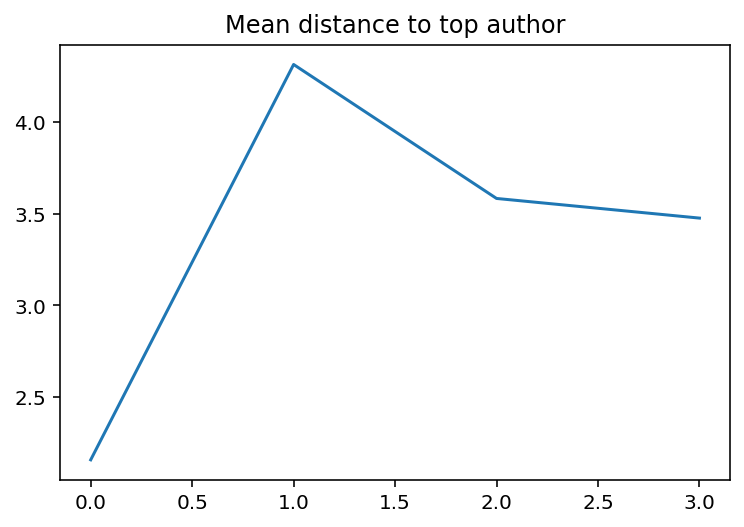

In [135]:
plt.plot(avg_bacon_numbers)
plt.title("Mean distance to top author")

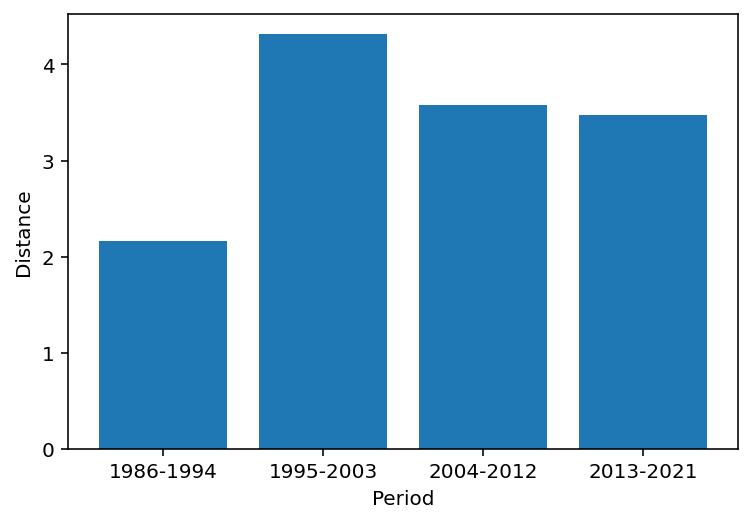

In [136]:
plt.bar(labels, avg_bacon_numbers)
# plt.title("Mean distance to top author")
plt.xlabel("Period")
plt.ylabel("Distance")
plt.savefig("figs2/bacon_number.pdf")

Text(0.5, 1.0, 'Max cluster size')

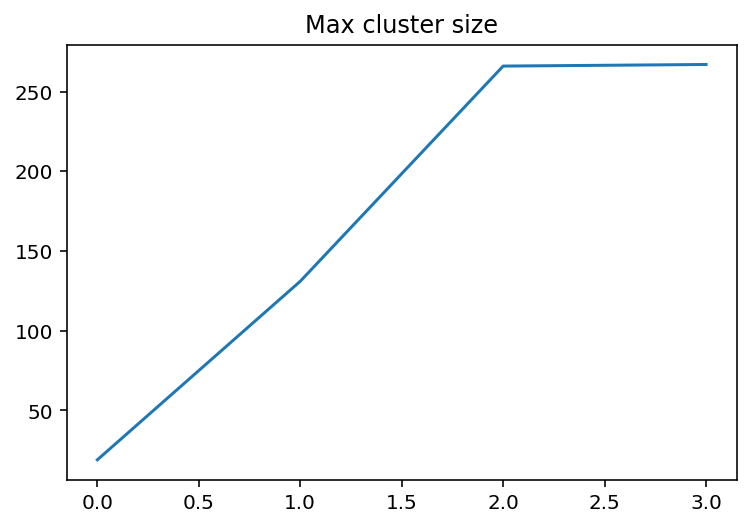

In [137]:
plt.plot(cluster_sizes)
plt.title("Max cluster size")

Text(0.5, 1.0, 'Total authors')

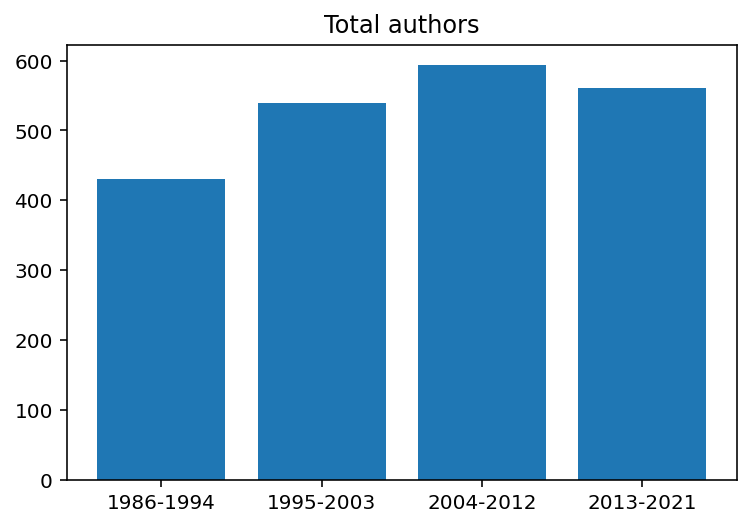

In [138]:
plt.bar(labels, [len(h) for h in Gs])
plt.title("Total authors")

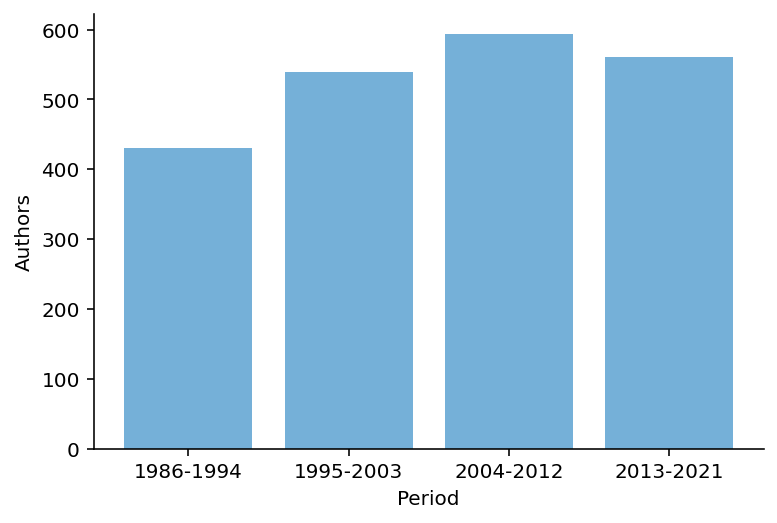

In [139]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(labels, [len(h) for h in Gs], color="#75b0d8")
# plt.title("Total authors")
plt.xlabel("Period")
plt.ylabel("Authors")
plt.savefig("figs2/author_count.pdf")

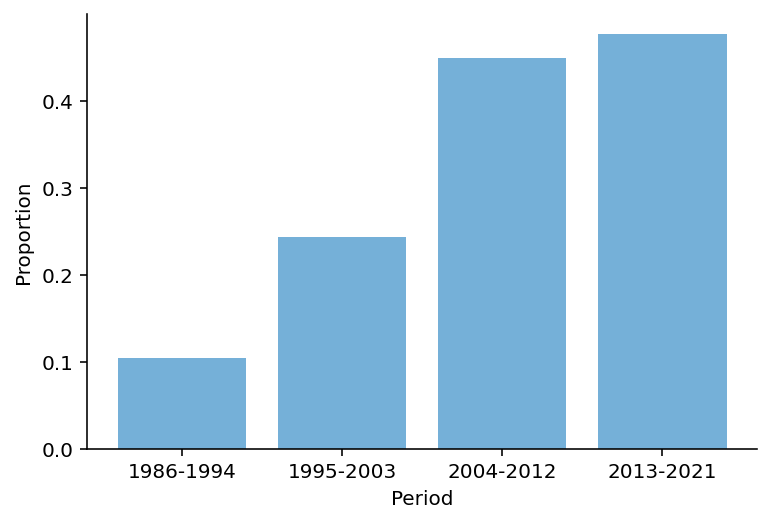

In [140]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(labels, [len(Hs[i])/len(Gs[i]) for i in range(4)], color="#75b0d8")
# plt.title("Proportion of authors in largest cluster")
plt.xlabel("Period")
plt.ylabel("Proportion")
plt.savefig("figs2/largest_prop.pdf")

Text(0.5, 0, 'Period')

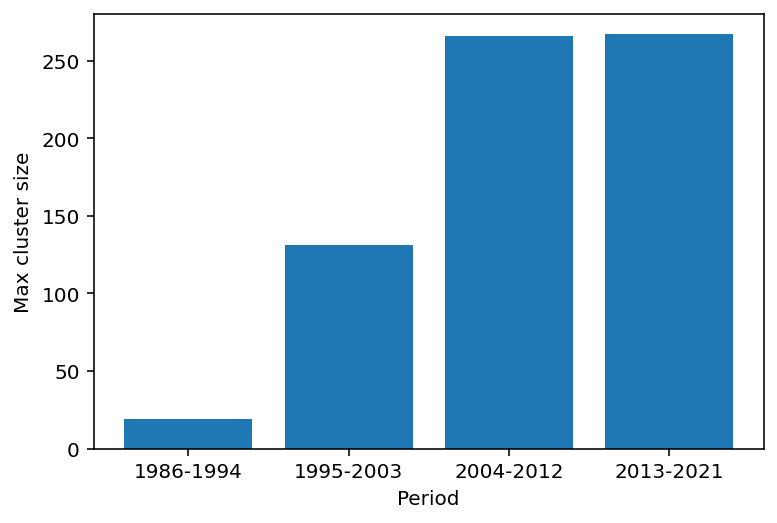

In [141]:
plt.bar(labels, cluster_sizes)
# plt.title("Max cluster size")
plt.ylabel("Max cluster size")
plt.xlabel("Period")

In [142]:
institutions_per_year = []
for year in years:
    dois = dois_for_years[year]
    institution_counts = []
    for doi in dois:
        if doi in insts_for_doi:
            institution_counts.append(len(insts_for_doi[doi]))
    institutions_per_year.append(institution_counts)

#list(map(np.mean, institutions_per_year))

In [143]:
inst_means = []
auth_count_means = []
inst_medians = []
for dois in chunks:
    institution_counts = []
    auth_count = []
    for doi in dois:
        auth_count.append(len(authors_for_doi[doi]))
        if doi in insts_for_doi:
            institution_counts.append(len(insts_for_doi[doi]))
    inst_means.append(np.mean(institution_counts))
    inst_medians.append(np.median(institution_counts))
    auth_count_means.append(np.mean(auth_count))

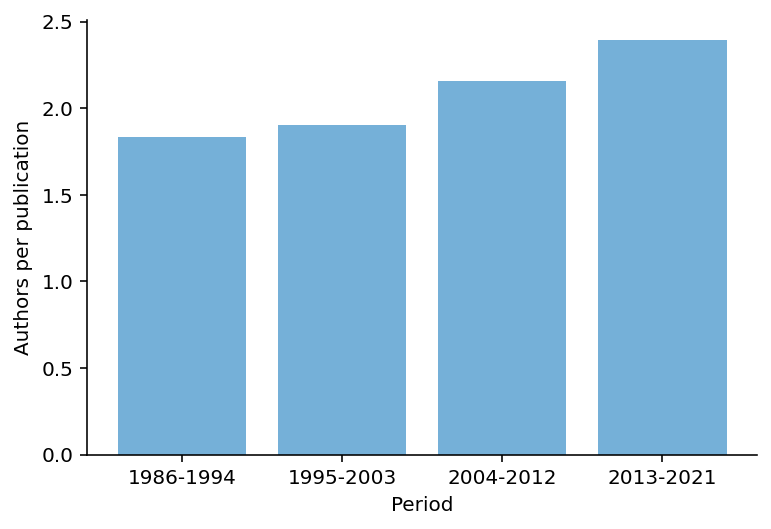

In [144]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(labels, auth_count_means, color="#75b0d8")
# plt.title("Average number of authors per publication")
plt.xlabel("Period")
plt.ylabel("Authors per publication")
plt.savefig("figs2/author_avgs.pdf")

In [145]:
auth_count_means

[1.8346456692913387, 1.9031578947368422, 2.1577825159914714, 2.3925]

In [146]:
inst_means

[1.4492753623188406,
 1.5175644028103044,
 1.6862302483069977,
 1.8303341902313626]

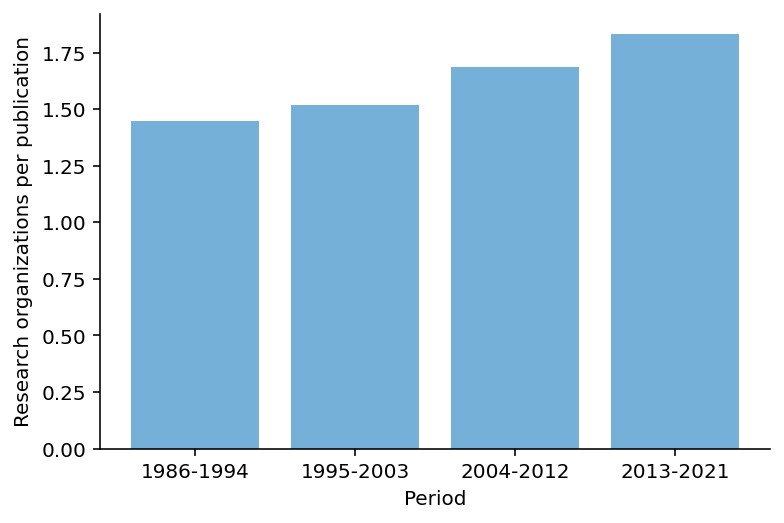

In [147]:
fig, ax = plt.subplots()
# ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.bar(labels, inst_means, color="#75b0d8")
# plt.title("Average unique research organizations per publication")
plt.xlabel("Period")
plt.ylabel("Research organizations per publication")
plt.savefig("figs2/institution_avgs.pdf")